# Transfer Learning 5 years later Walters et al.: 3 domain features
# Table of contents 
1. [Linear Regression](#LinearRegression)
2. [MLP (Dense)](#MLP)
3. [AE combined latent subset features](#AE_combined_subsetFeatures)
4. [AE combined latent all features](#AE_combined_allFeatures)
5. [AE OTU latent](#AE_latentOTU)

In [117]:
from data import *
from train_2 import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [118]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_2otufiles_fewerDomainFeatures(
              metadata_names=['age','Temperature','Precipitation3Days'],
              otu_filename='data/otu_table_all_80.csv',
              metadata_filename='data/metadata_table_all_80.csv',
              otu_transfer_filename='data/Walters5yearsLater/otu_table_Walters5yearsLater.csv',
              metadata_transfer_filename='data/Walters5yearsLater/metadata_table_Walters5yearsLater.csv')

In [119]:
print(df_domain_train.shape)
print(df_domain_test.shape)
print(df_domain_transfer_learning_train.shape)
print(df_domain_transfer_learning_test.shape)

(4251, 3)
(373, 3)
(29, 3)
(13, 3)


In [136]:
print('TRAIN:')
print('age:' + str(df_domain_transfer_learning_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_transfer_learning_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_test.loc[:,'Temperature'].mean()))

TRAIN:
age:8.344827586206897
rain:0.2737931034482759
Tª:71.4896551724138
TEST:
age:8.0
rain:0.23
Tª:70.4076923076923


### Get numpy transfer_learning objects

In [137]:
data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

# 1. Linear regression <a name="LinearRegression"></a>

In [139]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [140]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None)
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [141]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 1.2327 (min: 1.1468, max: 1.3008)

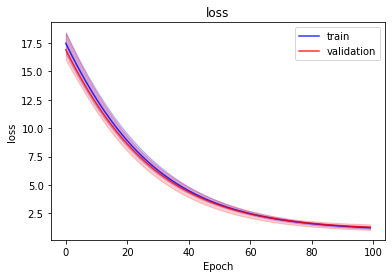

<b>domain_BrayCurtis</b>: 0.3468 (min: 0.3054, max: 0.3661)

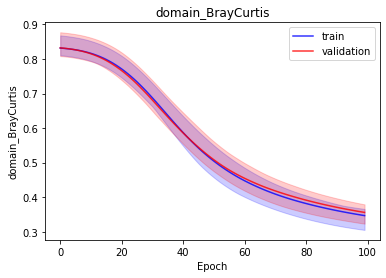

<b>domain_pearson_corr</b>: 0.6185 (min: 0.5433, max: 0.7644)

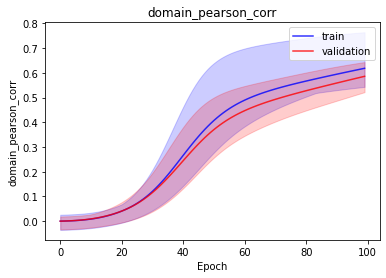

<b>domain_jensen_shannon_divergence</b>: 0.5060 (min: 0.3919, max: 0.6223)

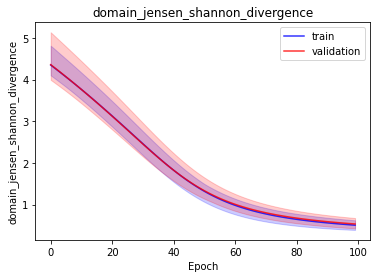

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.2326680183410645 | 1.1468442678451538 | 1.3008410930633545 |
| domain_BrayCurtis | 0.3467775881290436 | 0.3053622841835022 | 0.36608561873435974 |
| domain_pearson_corr | 0.6184728741645813 | 0.5433151721954346 | 0.7644429206848145 |
| domain_jensen_shannon_divergence | 0.5060137510299683 | 0.3919447958469391 | 0.6222939491271973 |


[('best_lost_epoch', 99),
 ('val_loss', [1.2871196031570435, 1.0399231910705566, 1.5262951850891113]),
 ('val_domain_BrayCurtis', [0.3559882, 0.32344964, 0.3792945]),
 ('val_domain_pearson_corr', [0.5860276, 0.52207524, 0.6436508]),
 ('val_domain_jensen_shannon_divergence', [0.5343625, 0.42902806, 0.6774629])]

In [142]:
print_results(results)

In [143]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.3714025914669037 | 0.3318910598754883 | 0.39288732409477234 |
| pearson_corr | 0.5822747945785522 | 0.48351219296455383 | 0.7537364959716797 |
| jensen_shannon_divergence | 0.5870648622512817 | 0.4569507837295532 | 0.7122905254364014 |


In [144]:
predictions

array([[0.0002348 , 0.00025222, 0.00013101, ..., 0.00269851, 0.00011873,
        0.00036475],
       [0.00032993, 0.00033772, 0.00014694, ..., 0.00281466, 0.00013276,
        0.00044241],
       [0.00024292, 0.00026311, 0.00013693, ..., 0.00259704, 0.00014123,
        0.00038163],
       ...,
       [0.00024244, 0.00026421, 0.00015127, ..., 0.00253907, 0.00016428,
        0.00039249],
       [0.00039927, 0.00040065, 0.00025272, ..., 0.00301766, 0.00017986,
        0.00054841],
       [0.00024292, 0.00026311, 0.00013693, ..., 0.00259704, 0.00014123,
        0.00038163]], dtype=float32)

# 2. MLP (Dense) <a name="MLP"></a>

In [145]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [146]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.01),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [147]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>76</b></p>

<b>loss</b>: 0.7082 (min: 0.6868, max: 0.7233)

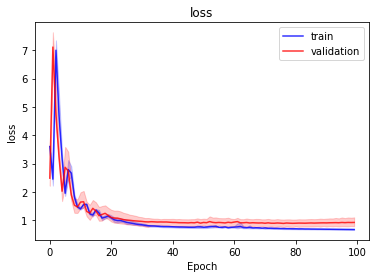

<b>domain_BrayCurtis</b>: 0.2445 (min: 0.2355, max: 0.2489)

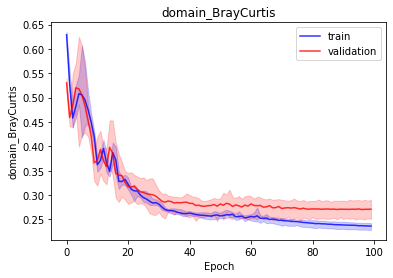

<b>domain_pearson_corr</b>: 0.8128 (min: 0.8044, max: 0.8333)

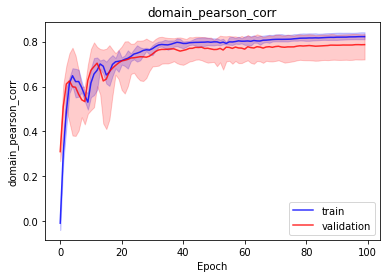

<b>domain_jensen_shannon_divergence</b>: 0.2575 (min: 0.2304, max: 0.2735)

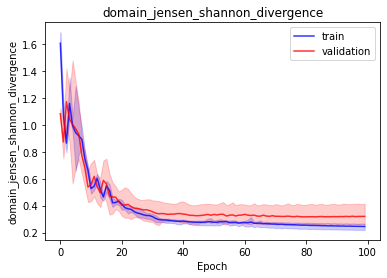

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.7081986904144287 | 0.6868120431900024 | 0.7232868075370789 |
| domain_BrayCurtis | 0.2445193976163864 | 0.23546355962753296 | 0.2488795518875122 |
| domain_pearson_corr | 0.8127602338790894 | 0.8044435977935791 | 0.8332971334457397 |
| domain_jensen_shannon_divergence | 0.2575228810310364 | 0.23037996888160706 | 0.2735181748867035 |


[('best_lost_epoch', 76),
 ('val_loss', [0.889715600013733, 0.7599401473999023, 1.027032494544983]),
 ('val_domain_BrayCurtis', [0.27138495, 0.24745314, 0.28731665]),
 ('val_domain_pearson_corr', [0.77683806, 0.7131934, 0.82723236]),
 ('val_domain_jensen_shannon_divergence', [0.3173658, 0.25927415, 0.4040977])]

In [148]:
print_results(results)

In [149]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2759576141834259 | 0.27260828018188477 | 0.2798932194709778 |
| pearson_corr | 0.7896710634231567 | 0.7864620685577393 | 0.7928979396820068 |
| jensen_shannon_divergence | 0.3220594525337219 | 0.30926424264907837 | 0.3335220217704773 |


In [150]:
predictions

array([[1.9516499e-04, 1.0305882e-04, 1.0481413e-04, ..., 2.0602483e-03,
        1.1269857e-04, 1.9725498e-04],
       [1.7714300e-04, 1.9394179e-04, 1.0691550e-04, ..., 3.4076597e-03,
        5.0747076e-05, 2.8215739e-04],
       [1.6271723e-04, 8.3809886e-05, 9.6921322e-05, ..., 1.6500067e-03,
        1.7884224e-04, 1.3984003e-04],
       ...,
       [1.4574596e-04, 6.1378138e-05, 8.3497129e-05, ..., 1.2478364e-03,
        2.4794246e-04, 1.0454507e-04],
       [2.8345993e-04, 1.7326442e-04, 9.3056042e-05, ..., 3.3234502e-03,
        3.1107666e-05, 4.6362722e-04],
       [1.6271726e-04, 8.3809893e-05, 9.6921343e-05, ..., 1.6500065e-03,
        1.7884225e-04, 1.3984002e-04]], dtype=float32)

# 3. Auto-encoder combined latent subset features <a name="AE_combined_subsetFeatures"></a>

### Get numpy train objects

In [16]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [17]:
data_domain_train.shape[1]

3

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>86</b></p>

<b>loss</b>: 0.6231 (min: 0.6231, max: 0.6231)

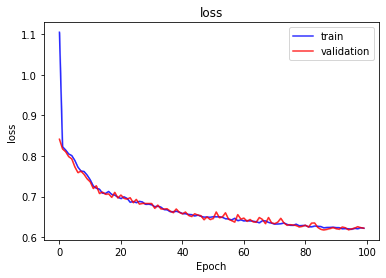

<b>bioma_loss</b>: 0.1954 (min: 0.1954, max: 0.1954)

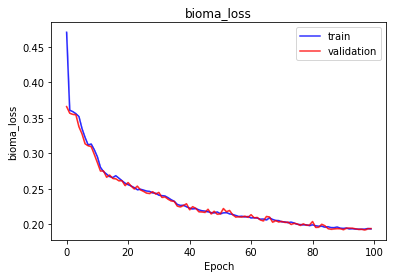

<b>domain_loss</b>: 0.4086 (min: 0.4086, max: 0.4086)

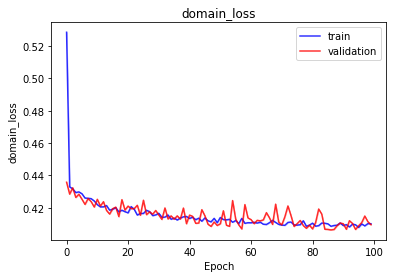

<b>latent_loss</b>: 0.0191 (min: 0.0191, max: 0.0191)

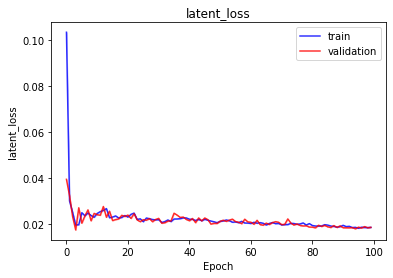

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

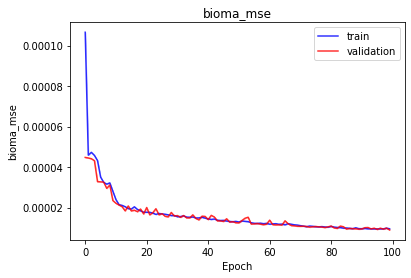

<b>bioma_mae</b>: 0.0005 (min: 0.0005, max: 0.0005)

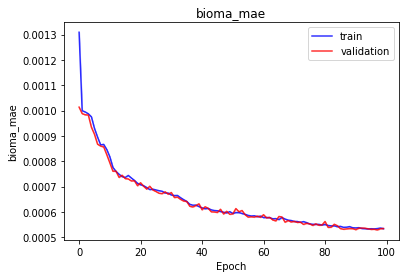

<b>bioma_mape</b>: 4840.4062 (min: 4840.4062, max: 4840.4062)

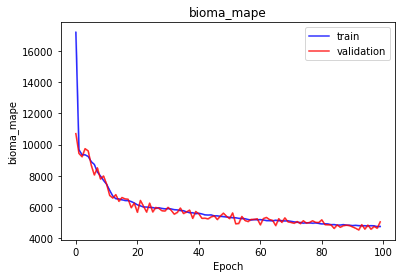

<b>bioma_BrayCurtis</b>: 0.1954 (min: 0.1954, max: 0.1954)

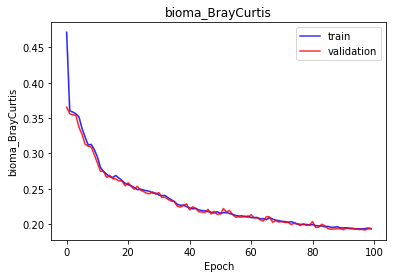

<b>bioma_pearson_corr</b>: 0.9274 (min: 0.9274, max: 0.9274)

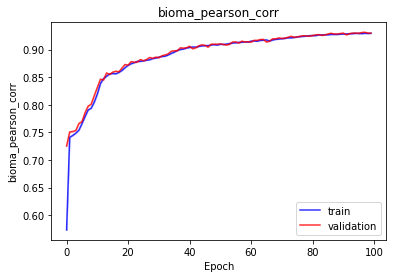

<b>bioma_jensen_shannon_divergence</b>: 0.3339 (min: 0.3339, max: 0.3339)

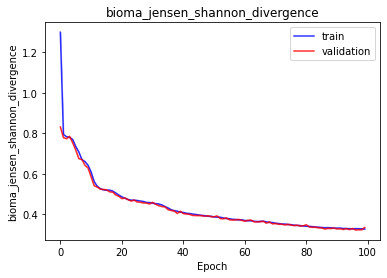

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

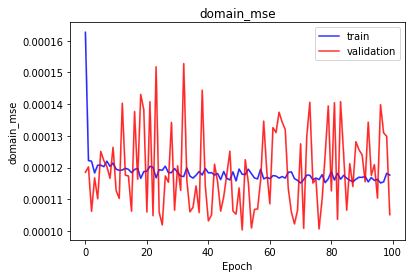

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

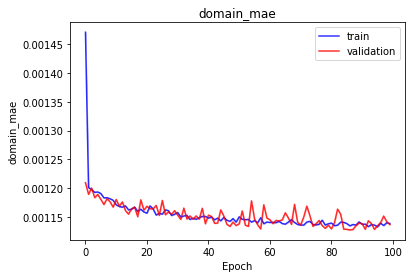

<b>domain_mape</b>: 8087.5776 (min: 8087.5776, max: 8087.5776)

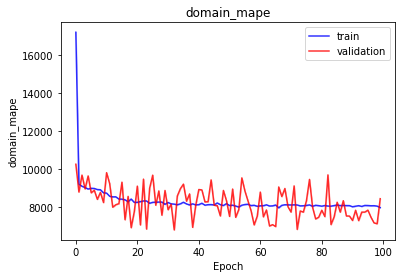

<b>domain_BrayCurtis</b>: 0.4086 (min: 0.4086, max: 0.4086)

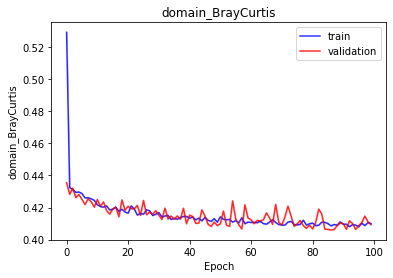

<b>domain_pearson_corr</b>: 0.7265 (min: 0.7265, max: 0.7265)

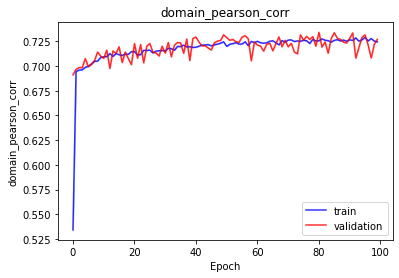

<b>domain_jensen_shannon_divergence</b>: 0.8983 (min: 0.8983, max: 0.8983)

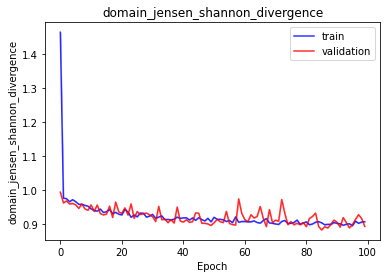

<b>latent_mae</b>: 0.0191 (min: 0.0191, max: 0.0191)

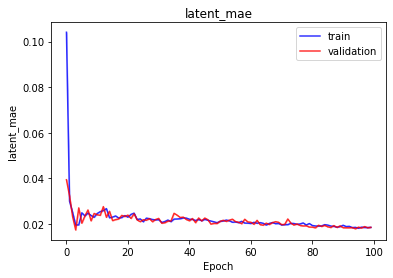

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6230566699177875 | 0.6230566699177875 | 0.6230566699177875 |
| bioma_loss | 0.1954420804977417 | 0.1954420804977417 | 0.1954420804977417 |
| domain_loss | 0.40855643153190613 | 0.40855643153190613 | 0.40855643153190613 |
| latent_loss | 0.019068285822868347 | 0.019068285822868347 | 0.019068285822868347 |
| bioma_mse | 9.783483619685285e-06 | 9.783483619685285e-06 | 9.783483619685285e-06 |
| bioma_mae | 0.0005393112078309059 | 0.0005393112078309059 | 0.0005393112078309059 |
| bioma_mape | 4840.40625 | 4840.40625 | 4840.40625 |
| bioma_BrayCurtis | 0.19538778066635132 | 0.19538778066635132 | 0.19538778066635132 |
| bioma_pearson_corr | 0.9274447560310364 | 0.9274447560310364 | 0.9274447560310364 |
| bioma_jensen_shannon_divergence | 0.3338826894760132 | 0.3338826894760132 | 0.3338826894760132 |
| domain_mse | 0.00011603492748690769 | 0.00011603492748690769 | 0.00011603492748690769 |
| domain_mae | 0.0011342684738337994 | 0.0011342684738337994 | 0.0011342684738337994 |
| domain_mape | 8087.57763671875 | 8087.57763671875 | 8087.57763671875 |
| domain_BrayCurtis | 0.4086041748523712 | 0.4086041748523712 | 0.4086041748523712 |
| domain_pearson_corr | 0.7265234589576721 | 0.7265234589576721 | 0.7265234589576721 |
| domain_jensen_shannon_divergence | 0.8983076810836792 | 0.8983076810836792 | 0.8983076810836792 |
| latent_mae | 0.019064750522375107 | 0.019064750522375107 | 0.019064750522375107 |


*************

In [18]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [19]:
model, encoder, encoder_domain, decoder = models[0]

### To predict latent space for samples in transfer learning Walters et al. subset

In [20]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neurons latent space

In [21]:
def model_fn_tl():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [22]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
#print(result_tl)

In [23]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.0013044613879173994 | 2.577234070599843e-08 | 0.02733226679265499 |


### a) Domain -> latent -> microbiome. Test set TL

In [24]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.7417764067649841 | 0.7417764067649841 | 0.7417764067649841 |
| pearson_corr | 0.007358225528150797 | 0.007358225528150797 | 0.007358225528150797 |
| jensen_shannon_divergence | 2.7642436027526855 | 2.7642436027526855 | 2.7642436027526855 |


### b) With the encoder_domain (best case)

In [25]:
# Test with encoder_biome, en vez de model_tl
predictions = test_model_tl_noEnsemble(encoder_domain, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.8192179799079895 | 0.8192179799079895 | 0.8192179799079895 |
| pearson_corr | -0.004805717151612043 | -0.004805717151612043 | -0.004805717151612043 |
| jensen_shannon_divergence | 4.200616836547852 | 4.200616836547852 | 4.200616836547852 |


# 4. Auto-encoder combined latent All features <a name="AE_combined_allFeatures"></a>

In [26]:
from train import *

### Get datasets with ALL domain features and numpy train objects

In [27]:
#df_microbioma_train, df_microbioma_test, \
#df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
#df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
#otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [28]:
#data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
#data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [29]:
data_domain_train.shape[1]

36

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.6281 (min: 0.6281, max: 0.6281)

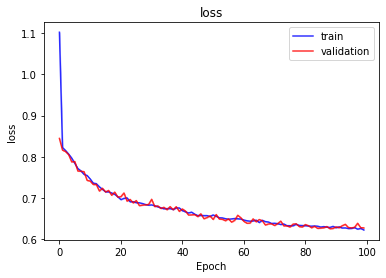

<b>bioma_loss</b>: 0.2035 (min: 0.2035, max: 0.2035)

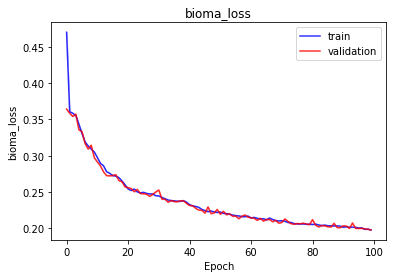

<b>domain_loss</b>: 0.4066 (min: 0.4066, max: 0.4066)

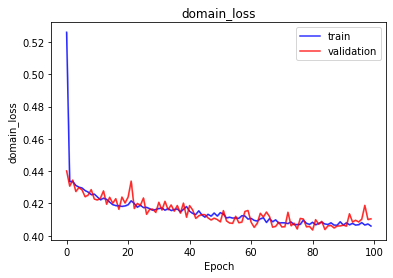

<b>latent_loss</b>: 0.0181 (min: 0.0181, max: 0.0181)

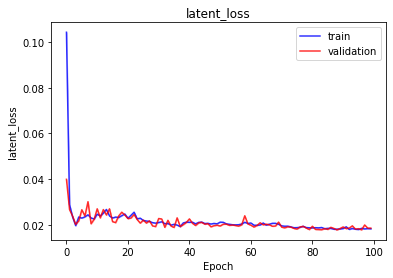

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

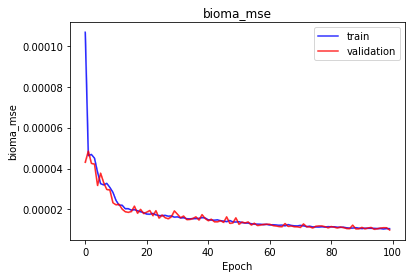

<b>bioma_mae</b>: 0.0006 (min: 0.0006, max: 0.0006)

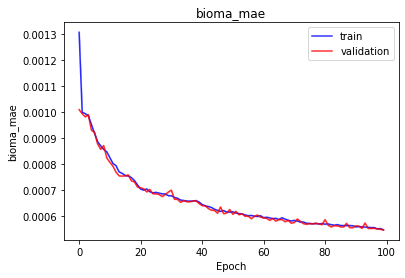

<b>bioma_mape</b>: 4990.9136 (min: 4990.9136, max: 4990.9136)

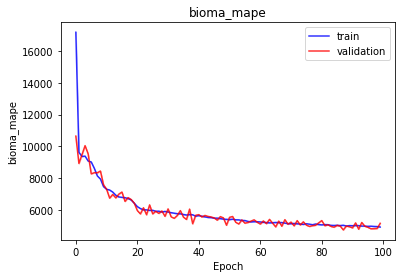

<b>bioma_BrayCurtis</b>: 0.2037 (min: 0.2037, max: 0.2037)

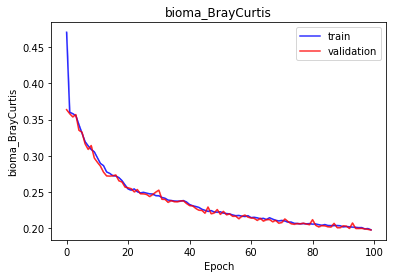

<b>bioma_pearson_corr</b>: 0.9189 (min: 0.9189, max: 0.9189)

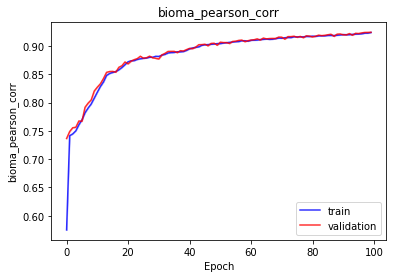

<b>bioma_jensen_shannon_divergence</b>: 0.3575 (min: 0.3575, max: 0.3575)

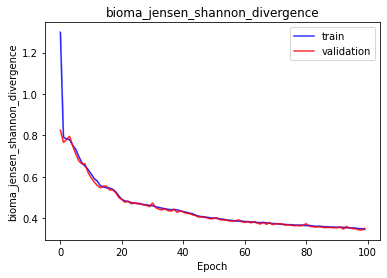

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

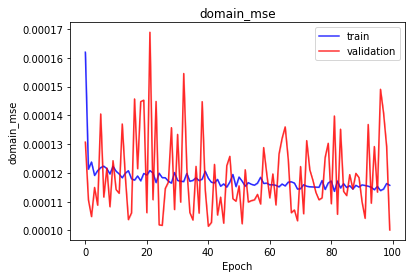

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

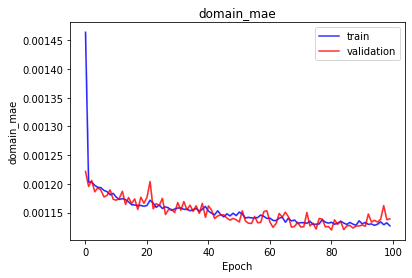

<b>domain_mape</b>: 8071.3364 (min: 8071.3364, max: 8071.3364)

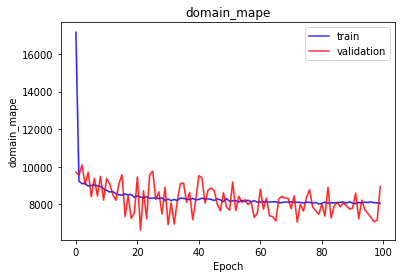

<b>domain_BrayCurtis</b>: 0.4063 (min: 0.4063, max: 0.4063)

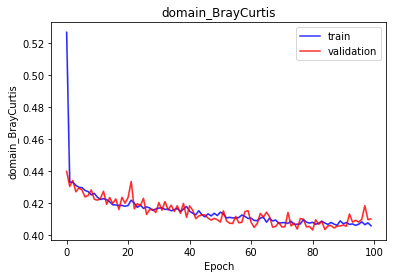

<b>domain_pearson_corr</b>: 0.7299 (min: 0.7299, max: 0.7299)

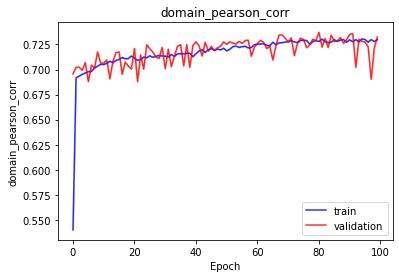

<b>domain_jensen_shannon_divergence</b>: 0.8937 (min: 0.8937, max: 0.8937)

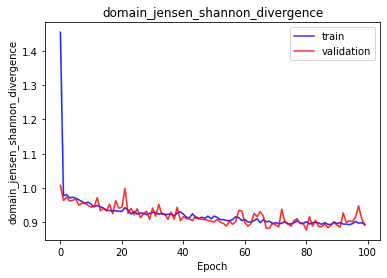

<b>latent_mae</b>: 0.0181 (min: 0.0181, max: 0.0181)

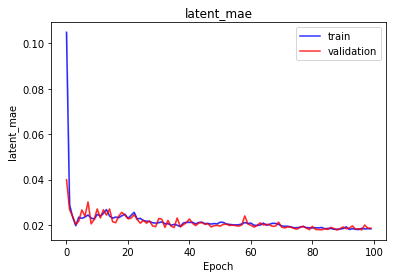

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6281308365468277 | 0.6281308365468277 | 0.6281308365468277 |
| bioma_loss | 0.20353731513023376 | 0.20353731513023376 | 0.20353731513023376 |
| domain_loss | 0.40655675530433655 | 0.40655675530433655 | 0.40655675530433655 |
| latent_loss | 0.018124405294656754 | 0.018124405294656754 | 0.018124405294656754 |
| bioma_mse | 1.11272174763144e-05 | 1.11272174763144e-05 | 1.11272174763144e-05 |
| bioma_mae | 0.0005624765763059258 | 0.0005624765763059258 | 0.0005624765763059258 |
| bioma_mape | 4990.91357421875 | 4990.91357421875 | 4990.91357421875 |
| bioma_BrayCurtis | 0.2036895602941513 | 0.2036895602941513 | 0.2036895602941513 |
| bioma_pearson_corr | 0.918918788433075 | 0.918918788433075 | 0.918918788433075 |
| bioma_jensen_shannon_divergence | 0.3575323224067688 | 0.3575323224067688 | 0.3575323224067688 |
| domain_mse | 0.00011569513299036771 | 0.00011569513299036771 | 0.00011569513299036771 |
| domain_mae | 0.0011279369937255979 | 0.0011279369937255979 | 0.0011279369937255979 |
| domain_mape | 8071.33642578125 | 8071.33642578125 | 8071.33642578125 |
| domain_BrayCurtis | 0.40633508563041687 | 0.40633508563041687 | 0.40633508563041687 |
| domain_pearson_corr | 0.7299425005912781 | 0.7299425005912781 | 0.7299425005912781 |
| domain_jensen_shannon_divergence | 0.8937239050865173 | 0.8937239050865173 | 0.8937239050865173 |
| latent_mae | 0.018106121569871902 | 0.018106121569871902 | 0.018106121569871902 |


*************

In [30]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh',
                        show_results=True, 
                        device='/CPU:0')

In [31]:
data_domain_train.shape

(4251, 36)

### To get encoders and decoders to use in transfer learning model

In [32]:
model, encoder, encoder_domain, decoder = models[0]

### To recover data with subset domain features

In [33]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_2otufiles_fewerDomainFeatures(
              metadata_names=['age','Temperature','Precipitation3Days'],
              otu_filename='data/otu_table_all_80.csv',
              metadata_filename='data/metadata_table_all_80.csv',
              otu_transfer_filename='data/Walters5yearsLater/otu_table_Walters5yearsLater.csv',
              metadata_transfer_filename='data/Walters5yearsLater/metadata_table_Walters5yearsLater.csv')

In [34]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in transfer learning Walters et al. subset

In [35]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 

In [36]:
def model_fn_tl():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [37]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
#print(result_tl)

In [38]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.0015244242968037724 | 1.9637144532680395e-07 | 0.029872562736272812 |


### Domain -> latent -> microbiome. Test set TL

In [39]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.7619184255599976 | 0.7619184255599976 | 0.7619184255599976 |
| pearson_corr | -0.00597772840410471 | -0.00597772840410471 | -0.00597772840410471 |
| jensen_shannon_divergence | 3.0058529376983643 | 3.0058529376983643 | 3.0058529376983643 |


# 5. Auto-encoder OTU latent <a name="AE_latentOTU"></a>

In [40]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [41]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [42]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)

In [43]:
data_microbioma_train.shape[1]

717

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1631 (min: 0.1631, max: 0.1631)

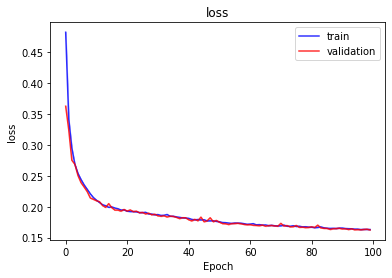

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

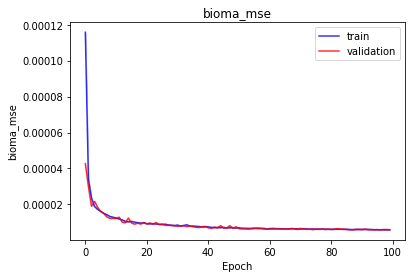

<b>bioma_mae</b>: 0.0004 (min: 0.0004, max: 0.0004)

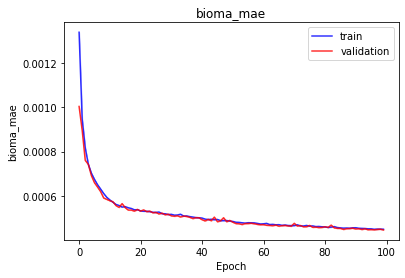

<b>bioma_mape</b>: 4060.0955 (min: 4060.0955, max: 4060.0955)

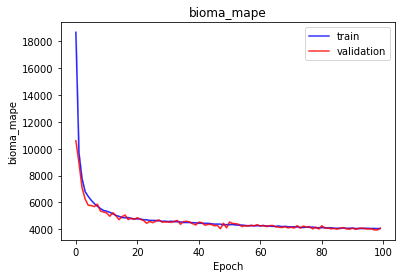

<b>bioma_BrayCurtis</b>: 0.1631 (min: 0.1631, max: 0.1631)

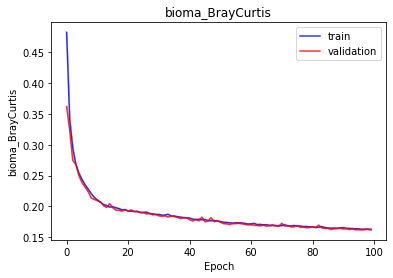

<b>bioma_pearson_corr</b>: 0.9495 (min: 0.9495, max: 0.9495)

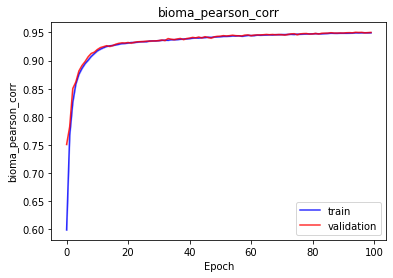

<b>bioma_jensen_shannon_divergence</b>: 0.2646 (min: 0.2646, max: 0.2646)

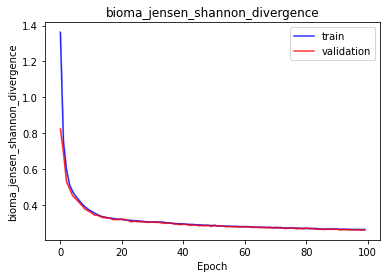

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16313993290743248 | 0.16313993290743248 | 0.16313993290743248 |
| bioma_mse | 5.9371814131736755e-06 | 5.9371814131736755e-06 | 5.9371814131736755e-06 |
| bioma_mae | 0.00044932746095582843 | 0.00044932746095582843 | 0.00044932746095582843 |
| bioma_mape | 4060.095458984375 | 4060.095458984375 | 4060.095458984375 |
| bioma_BrayCurtis | 0.1631399542093277 | 0.1631399542093277 | 0.1631399542093277 |
| bioma_pearson_corr | 0.9494578838348389 | 0.9494578838348389 | 0.9494578838348389 |
| bioma_jensen_shannon_divergence | 0.264644593000412 | 0.264644593000412 | 0.264644593000412 |


*************

In [44]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [45]:
model, encoder, _ ,decoder = models[0]

### To recover data with subset domain features

In [78]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_2otufiles_fewerDomainFeatures(
              metadata_names=['age','Temperature','Precipitation3Days'],
              otu_filename='data/otu_table_all_80.csv',
              metadata_filename='data/metadata_table_all_80.csv',
              otu_transfer_filename='data/Walters5yearsLater/otu_table_Walters5yearsLater.csv',
              metadata_transfer_filename='data/Walters5yearsLater/metadata_table_Walters5yearsLater.csv')

### Get numpy transfer_learning objects

In [112]:
data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

### To predict latent space for samples in transfer learning Walters et al. subset

In [82]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

In [135]:
data_microbioma_transfer_learning_test

array([[  6.,  22.,   2., ..., 286.,  18.,  84.],
       [ 22.,  13.,   8., ..., 444.,   4., 340.],
       [  7.,  14.,   4., ..., 123.,  10.,  29.],
       ...,
       [  4.,   4.,   1., ...,  66.,  13.,   1.],
       [ 31.,   7.,   3., ..., 149.,   0.,  61.],
       [  9.,  14.,  10., ..., 785.,   8.,   8.]], dtype=float32)

### To build model to predict latent space 

In [85]:
def model_fn_tl():
    in_layer = layers.Input(shape=(3,))  
    #net = layers.Dense(64, activation='tanh')(in_layer)
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)  
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [86]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
print(result_tl)

In [87]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.07662570476531982 | 2.185736593673937e-05 | 1.3481557369232178 |


### Domain -> latent -> microbiome. Test set TL

In [88]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.7842683792114258 | 0.7842683792114258 | 0.7842683792114258 |
| pearson_corr | -0.00332159292884171 | -0.00332159292884171 | -0.00332159292884171 |
| jensen_shannon_divergence | 3.330713987350464 | 3.330713987350464 | 3.330713987350464 |
